# Converting between coordinate systems with Pyproj
**Scott Wales, CLEX CMS**

Pyproj is a helpful tool to use when you want to change your data's coordinate system

In [1]:
import xarray
import pyproj
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy

## Sample data in polar projection

The sample dataset here is [MEaSUREs BedMachine Antarctica, Version 2](https://nsidc.org/data/NSIDC-0756/versions/2)

In [2]:
data = xarray.open_dataset('/g/data/v45/pas561/bedmachineant/BedMachineAntarctica_2020-07-15_v02.nc', chunks={'x': 5000, 'y': 5000})

The dataset is quite large, 13333 by 13333 points. To make it easier to work with I'll subset the data to every 100th row and column

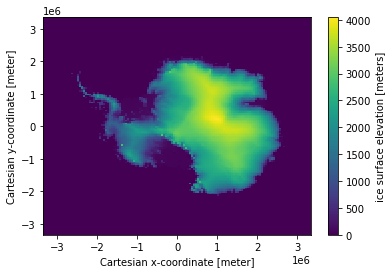

In [3]:
subset = data.isel(x=slice(None, None, 100), y=slice(None, None, 100))
subset.surface.plot()

As you can see the dataset is in a polar projection. Rather than having latitude and longitude coordinates it has 'x' and 'y' values, both in units of metres.

In [4]:
subset.x[:5]

<xarray.DataArray 'x' (x: 5)>
array([-3333000, -3283000, -3233000, -3183000, -3133000], dtype=int32)
Coordinates:
  * x        (x) int32 -3333000 -3283000 -3233000 -3183000 -3133000
Attributes:
    long_name:      Cartesian x-coordinate
    standard_name:  projection_x_coordinate
    units:          meter

There is information about the projection in the file metadata. The data is in a 'Polar Stereographic South' projection.

Also note the 'proj4' attribute - proj4 is a standard tool for working with cartographic projections. This is saying that the proj4 id of the projection is ['epsg:3031'](https://epsg.io/3031) (EPSG codes are standard names for different projections). 

In [5]:
subset.attrs

{'Conventions': 'CF-1.7',
 'Title': 'BedMachine Antarctica',
 'Author': 'Mathieu Morlighem',
 'version': '15-Jul-2020 (v2.0)',
 'nx': 13333.0,
 'ny': 13333.0,
 'Projection': 'Polar Stereographic South (71S,0E)',
 'proj4': '+init=epsg:3031',
 'sea_water_density (kg m-3)': 1027.0,
 'ice_density (kg m-3)': 917.0,
 'xmin': -3333000,
 'ymax': 3333000,
 'spacing': 500,
 'no_data': -9999.0,
 'license': 'No restrictions on access or use',
 'Data_citation': 'Morlighem M. et al., (2019), Deep glacial troughs and stabilizing ridges unveiled beneath the margins of the Antarctic ice sheet, Nature Geoscience (accepted)',
 'Notes': 'Data processed at the Department of Earth System Science, University of California, Irvine'}

## Converting coordinates with Pyproj

'pyproj' is a Python interface to proj4. We can use it to convert between different coordinate systems. The EPSG code for basic lat-lon coordinates is ['epsg:4326'](https://epsg.io/4326).

To convert between coordinate systems you create a 'Transformer', then 'transform' the coordinate values.

In [6]:
source_crs = 'epsg:3031' # Coordinate system of the file
target_crs = 'epsg:4326' # Global lat-lon coordinate system

polar_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)

If you just give the 1d coordinates from the file you see a somewhat weird pattern

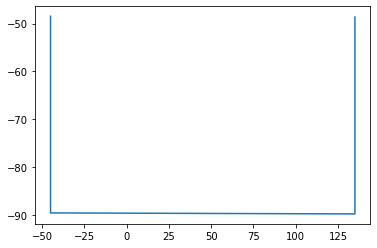

In [7]:
lat, lon = polar_to_latlon.transform(subset.x, subset.y)
plt.plot(lon, lat)

What's happening is clearer on a polar projection - you can see it's drawn a diagonal line. This is because pyproj pairs up the x and y values, rather than creating a grid

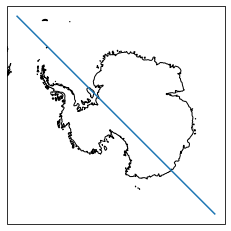

In [8]:
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.plot(lon, lat, transform=ccrs.PlateCarree())
ax.coastlines()

Since the latitude and longitude values are going to be 2d coordinates you need to use 'numpy.meshgrid' to fill out the axes before doing the conversion

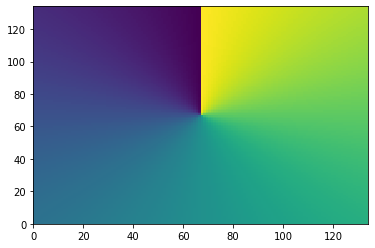

In [9]:
X, Y = numpy.meshgrid(subset.x, subset.y)
lat, lon = polar_to_latlon.transform(X, Y)

plt.pcolormesh(lon)

You can add the coordinates to the dataarray by adding to the `.coords` dictionary. This takes a tuple of (dimensions, data).

In [10]:
subset.coords['lat'] = (subset.surface.dims, lat)
subset.coords['lon'] = (subset.surface.dims, lon)

subset.surface

<xarray.DataArray 'surface' (y: 134, x: 134)>
dask.array<getitem, shape=(134, 134), dtype=float32, chunksize=(50, 50), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int32 -3333000 -3283000 -3233000 ... 3217000 3267000 3317000
  * y        (y) int32 3333000 3283000 3233000 ... -3217000 -3267000 -3317000
    lat      (y, x) float64 -48.46 -48.75 -49.03 -49.31 ... -49.22 -48.93 -48.65
    lon      (y, x) float64 -45.0 -44.57 -44.13 -43.68 ... 135.9 135.4 135.0
Attributes:
    long_name:      ice surface elevation
    standard_name:  surface_altitude
    units:          meters
    grid_mapping:   mapping
    source:         REMA (Byrd Polar and Climate Research Center and the Pola...

## Plotting with the new coordinates

Plotting the data shows it's the right coordinates, but the image is very messy

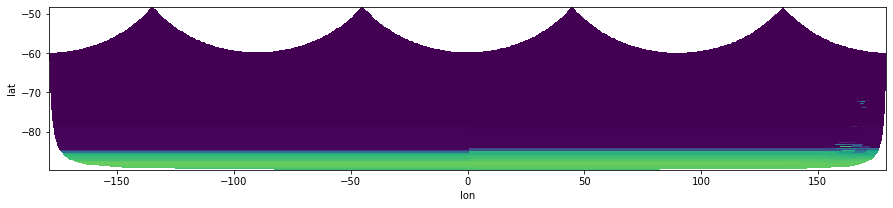

In [11]:
plt.figure(figsize=(15,3))
subset.surface.plot.pcolormesh('lon', 'lat', add_colorbar=False)

This is because the data wraps around, using a cartopy lat-lon projection on the plot cleans the image up.

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


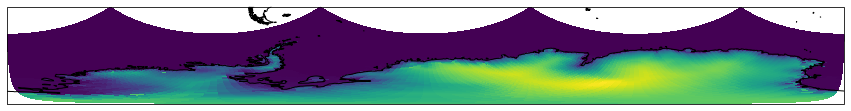

In [12]:
plt.figure(figsize=(15,3))
ax = plt.axes(projection=ccrs.PlateCarree())
subset.surface.plot.pcolormesh('lon', 'lat', ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines()

Note the blank areas in the corner though - there's a gap where the longitudes wrap around. The gap is still there when plotting the lat-lon data in a polar projection, it's a side effect of working in lat-lon coordinates at the poles.

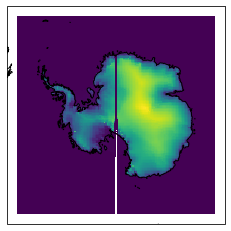

In [13]:
ax = plt.axes(projection=ccrs.SouthPolarStereo())
subset.surface.plot.pcolormesh('lon', 'lat', ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines()

## Converting from lat-lon to data coordinates

To avoid these singularities, sometimes it's better to convert the other way around, from lat-lon to the data cooridinates. Say we want to draw a lat-lon box on the polar view, created using this function

In [14]:
def lon_lat_box(lon_bounds, lat_bounds, refinement=2):
    """
    Coordinates along the boundary of a rectangle in lat-lon coordinates
    
    Args:
        lon_bounds: (min, max) lon values
        lat_bounds: (min, max) lat values
        refinement: number of points to draw along each edge
        
    Returns: (lons, lats)
    """
    lons = []
    lats = []
    
    lons.append(numpy.linspace(lon_bounds[0], lon_bounds[-1], num=refinement))
    lats.append(numpy.linspace(lat_bounds[0], lat_bounds[0], num=refinement))
                
    lons.append(numpy.linspace(lon_bounds[-1], lon_bounds[-1], num=refinement))
    lats.append(numpy.linspace(lat_bounds[0], lat_bounds[-1], num=refinement))
                
    lons.append(numpy.linspace(lon_bounds[-1], lon_bounds[0], num=refinement))
    lats.append(numpy.linspace(lat_bounds[-1], lat_bounds[-1], num=refinement))
    
    lons.append(numpy.linspace(lon_bounds[0], lon_bounds[0], num=refinement))
    lats.append(numpy.linspace(lat_bounds[-1], lat_bounds[0], num=refinement))
    
    return numpy.concatenate(lons), numpy.concatenate(lats)

First let's look at the box in the lat, lon coordinates

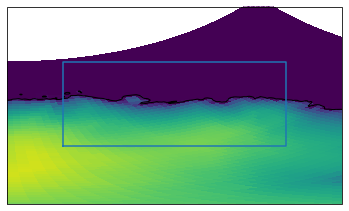

In [15]:
boxlon, boxlat = lon_lat_box([100,140],[-75,-60], refinement=100)

ax = plt.axes(projection=ccrs.PlateCarree())
subset.surface.plot.pcolormesh('lon', 'lat', ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
ax.plot(boxlon, boxlat, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([90,150,-85,-50])

Now the same box in data coodinates, converting the other way around to what we did before.

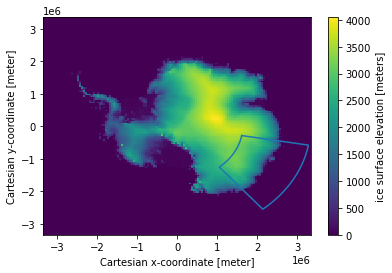

In [16]:
latlon_to_polar = pyproj.Transformer.from_crs(target_crs, source_crs)
boxx, boxy = latlon_to_polar.transform(boxlat, boxlon)

ax = plt.axes()
subset.surface.plot(ax=ax)
ax.plot(boxx, boxy)

You can use this method to do things like select a specific region using the box's data coordinate bounds (also see the [regionmask](https://regionmask.readthedocs.io) library) and otherwise work with datasets too large to convert from the file coordinates to lat-lon (converting the entire dataset here with pyproj takes a long time, we're only plotting every 100th point)

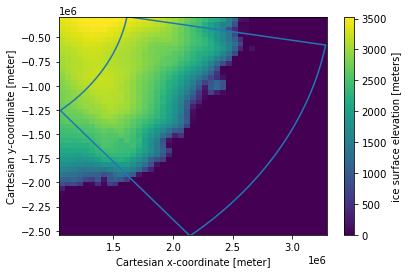

In [17]:
region = subset.sel(x=slice(boxx.min(), boxx.max()), y=slice(boxy.max(), boxy.min()))

ax = plt.axes()
region.surface.plot(ax=ax)
ax.plot(boxx, boxy)

## 3d coordinates

A way to get around singularities and wrapping issues is to work with the data in 3d coordinates. This needs a raw proj4 name of `'+proj=geocent'`, and also a Z input value (which can just be zero if everything's on the same level)

In [18]:
polar_to_cart = pyproj.Transformer.from_crs(source_crs, '+proj=geocent')
cX, cY, cZ = polar_to_cart.transform(X, Y, 0*X)

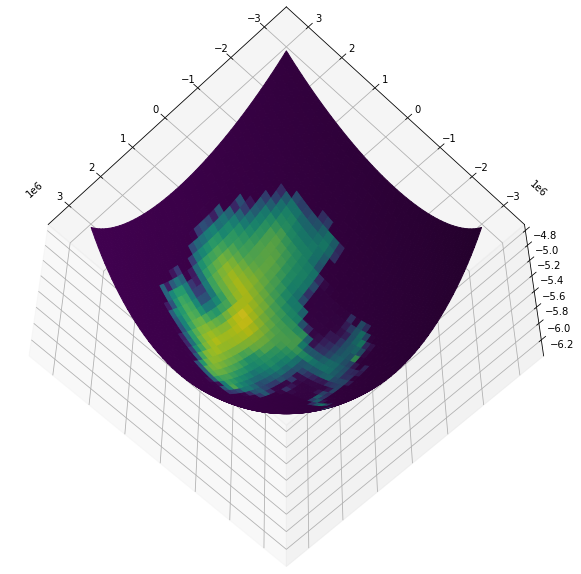

In [19]:
import matplotlib

plt.figure(figsize=(15,10))

# Make a 3d plot
ax = plt.axes(projection='3d')

# Use the values to colour the surface
cmap = plt.cm.ScalarMappable(cmap='viridis')
colors = cmap.to_rgba(subset.surface)

ax.plot_surface(cX, cY, cZ, facecolors=colors)

# Camera position
ax.elev = -60
ax.azim = 135